In [1]:
from sklearn.datasets import load_wine
import pandas as pd

In [2]:
wine = load_wine() # Loading wine data through api
df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
y = wine.target
print("Null count", df.isnull().sum().sum())

Null count 0


In [3]:
# Standarizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit and transform the data
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [4]:
from sklearn.decomposition import PCA

pca = PCA()
df_pca = pd.DataFrame(pca.fit_transform(df_scaled))

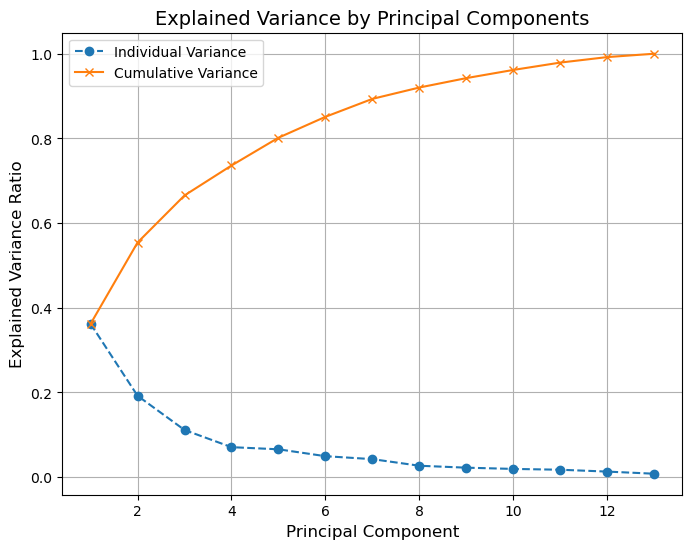

In [5]:
import matplotlib.pyplot as plt

explained_variance_ratio = pca.explained_variance_ratio_
# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label='Individual Variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='x', linestyle='-', label='Cumulative Variance')
plt.title('Explained Variance by Principal Components', fontsize=14)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.legend()
plt.grid()
plt.show()

We Use only 5 components to capture 80% of the data variance

In [6]:
pca = PCA(n_components=5)
df_pca = pd.DataFrame(pca.fit_transform(df_scaled))

## Training Kmeans and DBSCAN

The Silhouette Score is a measure of how similar each point is to its own cluster compared to other clusters. It provides an indication of the quality of the clusters formed by a clustering algorithm like K-Means.

In [7]:
import warnings
warnings.filterwarnings('ignore')

#### Scaled dataset:

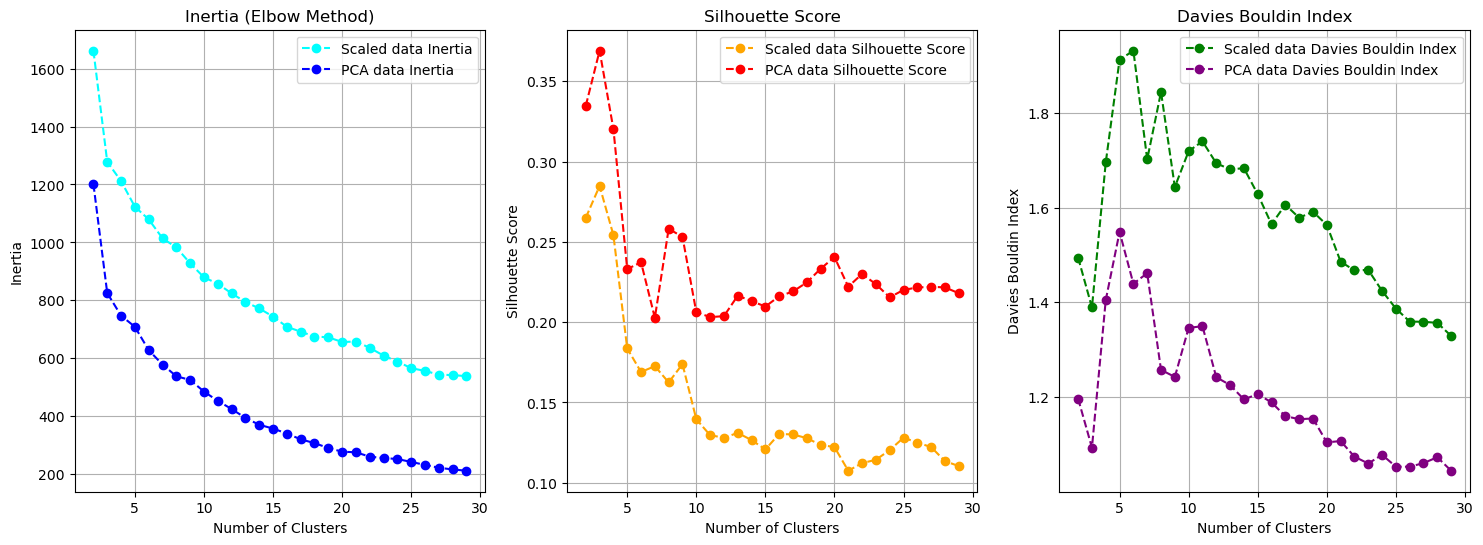

In [43]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score


inertia = []  # To store inertia values
silhouette_scores = []  # To store silhouette scores
dbis = []  # To store Davies Bouldin Index values

inertia_pca = []  # To store inertia values
silhouette_scores_pca = []  # To store silhouette scores
dbis_pca = []  # To store Davies Bouldin Index values

for n_clusters in range(2,30):
    # for scaled dataset:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_scaled)  # Fit the model on scaled data 
    inertia.append(kmeans.inertia_)  # Sum of squared distances to nearest cluster center
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))  # Silhouette score
    dbis.append(davies_bouldin_score(df_scaled, kmeans.labels_))
    
    # for pca dataset
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_pca)  # Fit the model on pca data
    inertia_pca.append(kmeans.inertia_)  # Sum of squared distances to nearest cluster center
    silhouette_scores_pca.append(silhouette_score(df_pca, kmeans.labels_))  # Silhouette score
    dbis_pca.append(davies_bouldin_score(df_pca, kmeans.labels_))

# Plot results
plt.figure(figsize=(18, 6))

# Plot inertia (Elbow Method)
plt.subplot(1, 3, 1)
plt.plot(range(2,30), inertia, marker='o', linestyle='--', label='Scaled data Inertia',color = "cyan")
plt.plot(range(2,30), inertia_pca, marker='o', linestyle='--', label='PCA data Inertia', color = "blue")

plt.title("Inertia (Elbow Method)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.legend()

# Plot silhouette score
plt.subplot(1, 3, 2)
plt.plot(range(2,30), silhouette_scores, marker='o', linestyle='--', color='orange', label='Scaled data Silhouette Score')
plt.plot(range(2,30), silhouette_scores_pca, marker='o', linestyle='--', color='red', label='PCA data Silhouette Score')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.legend()

# Plot Davies Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(range(2,30), dbis, marker='o', linestyle='--', color='green', label='Scaled data Davies Bouldin Index')
plt.plot(range(2,30), dbis_pca, marker='o', linestyle='--', color='purple', label='PCA data Davies Bouldin Index')
plt.title("Davies Bouldin Index")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies Bouldin Index")
plt.grid()
plt.legend()


In [83]:
best_score_Kmeans = max(silhouette_scores)
best_dbi_Kmeans = min(dbis)
best_score_pca_Kmeans = max(silhouette_scores_pca)
best_dbi_pca_Kmeans = min(dbis_pca)

We chose 3 based on Silhouette and dbi score both for pca data and scaled data

Text(50.722222222222214, 0.5, 'Actual')

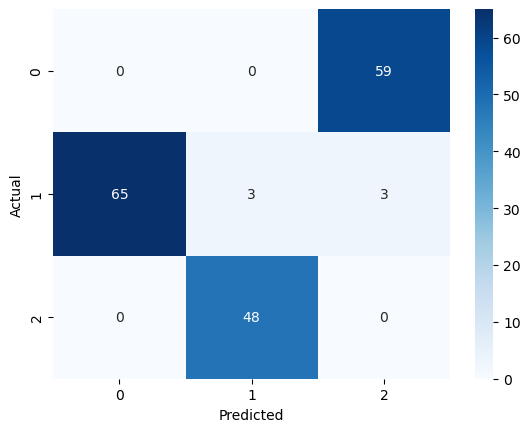

In [9]:
# using accuracy score and confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_pca)
y_pred = kmeans.labels_

# Calculate confusion matrix
cm = confusion_matrix(y, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [10]:
import numpy as np
mapping = {0:1, 1:2, 2:0}
# Remap KMeans labels
y_kmeans_mapped = [mapping[label] for label in y_pred]

In [11]:
silhouette_score(df_pca, kmeans.labels_)

0.3690763194699231

DBSCAN

In [65]:
from sklearn.model_selection import ParameterGrid
from math import inf
# Define the parameter grid


def dbscan_pipe(data,return_labels = False):
    param_grid = {
    'eps': np.linspace(0.1, 1.0, 10),  # Range of eps values
    'min_samples': range(2, 10)        # Range of min_samples values
        }
    best_score = -1
    best_params = None
    best_labels = None
    scores = []
    dbis = []
    for params in ParameterGrid(param_grid):
        # Apply DBSCAN
        dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
        labels = dbscan.fit_predict(data)
        # Skip if all points are noise or only one cluster is found
        if len(np.unique(labels)) == 1:
            score = -1 
            dbi_score = inf
        else:
            # Compute silhouette score
            score = silhouette_score(data, labels)
            dbi_score = davies_bouldin_score(data, labels)
        # Update best parameters if the current score is better
        if score > best_score:
            best_score = score
            best_params = params
            best_labels = labels
            
        scores.append(score)
        dbis.append(dbi_score) 
    if return_labels:
        return best_params, best_score, scores, dbis, best_labels
    return best_params, best_score, scores, dbis
    
    
best_params_scaled, best_score_scaled, scores_scaled, dbis_scaled = dbscan_pipe(df_scaled)
best_params_pca, best_score_pca, scores_pca, dbis_pca = dbscan_pipe(df_pca)

Best parameters for scaled data: None
Best parameters for PCA data: {'eps': 0.9, 'min_samples': 6}


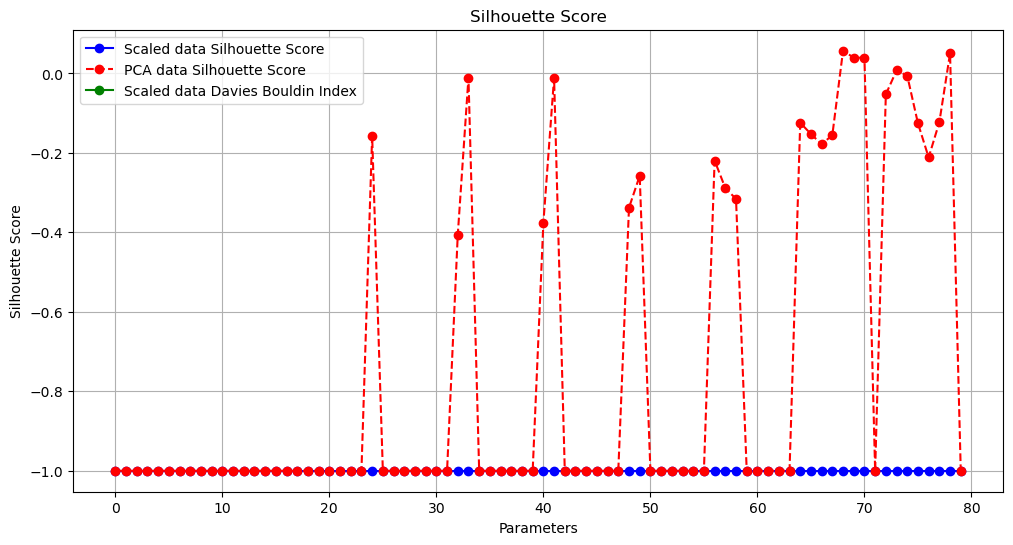

In [48]:
print('Best parameters for scaled data:', best_params_scaled)
print('Best parameters for PCA data:', best_params_pca)

#plotting the silhouette scores for both data
plt.figure(figsize=(12, 6))
plt.plot(range(len( scores_scaled)), scores_scaled, marker='o', linestyle='-', color='blue', label='Scaled data Silhouette Score')
plt.plot(range(len( scores_pca)), scores_pca, marker='o', linestyle='--', color='red', label='PCA data Silhouette Score',)
plt.title("Silhouette Score")
plt.xlabel("Parameters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid()
plt.show()

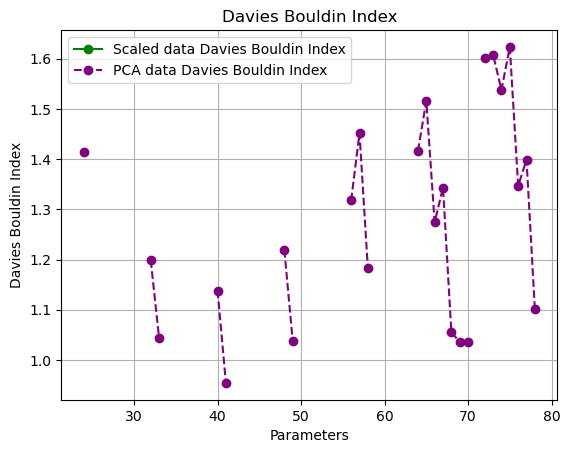

In [49]:
plt.plot(range(len( dbis_scaled)), dbis_scaled, marker='o', linestyle='-', color='green', label='Scaled data Davies Bouldin Index')
plt.plot(range(len( dbis_pca)), dbis_pca, marker='o', linestyle='--', color='purple', label='PCA data Davies Bouldin Index')
plt.title("Davies Bouldin Index")
plt.xlabel("Parameters")
plt.ylabel("Davies Bouldin Index")
plt.legend()
plt.grid()

In [84]:
# saving best metrics for both models as csv
scores_comparison = pd.DataFrame({('Kmeans','Silhouette'): [best_score_Kmeans, best_score_pca_Kmeans],
                                  ('Kmeans','Davies Bouldin Index'): [best_dbi_Kmeans, best_dbi_pca_Kmeans],
                                  ('DBSCAN','Silhouette'): [best_score_scaled, best_score_pca],
                                  ('DBSCAN','Davies Bouldin Index'): [min(dbis_scaled), min(dbis_pca)],
                                  }
                                    ,).T

scores_comparison.columns = ['Scaled', 'PCA']
scores_comparison.to_csv('scores_comparison.csv', index=False)
scores_comparison

Scaled       PCA
Kmeans Silhouette            0.284859  0.369076
       Davies Bouldin Index  1.329223  0.690010
DBSCAN Silhouette           -1.000000  0.447933
       Davies Bouldin Index       inf  0.690010

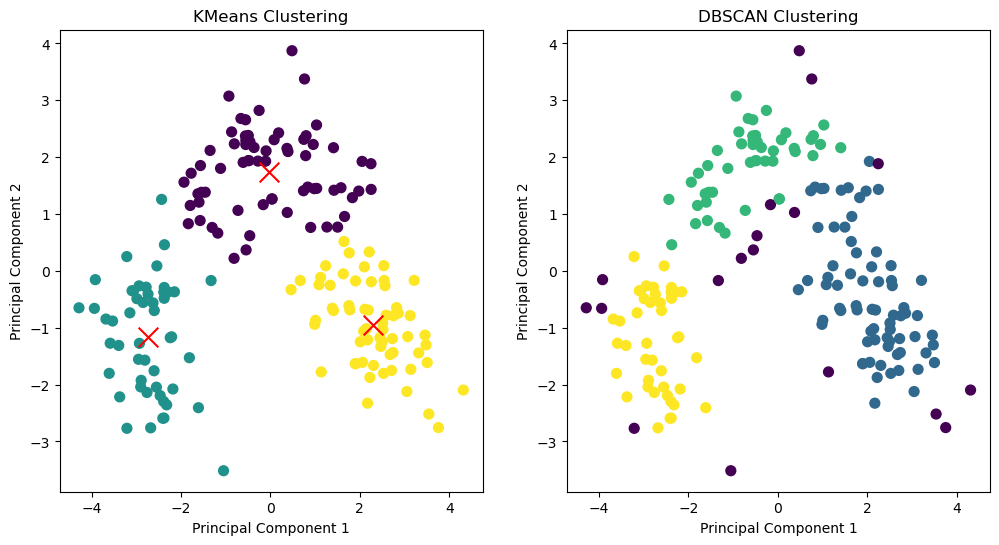

In [66]:
#using pca with 2 components
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df_scaled))

# Apply Kmeans and DBSCAN
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_pca)
best_params_pca, best_score_pca, scores_pca, dbis_pca, labels = dbscan_pipe(df_pca, return_labels=True)

# Plot KMeans clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(df_pca[0], df_pca[1], c=kmeans.labels_, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='x')
plt.title('KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot DBSCAN clusters
plt.subplot(1, 2, 2)
plt.scatter(df_pca[0], df_pca[1], c=labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
